In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import optimize
import random

In [2]:
T = pd.read_csv('/Users/siyangwei/Documents/ANES_datasets/anes_timeseries_cdf_csv_20220916/anes_timeseries_cdf_csv_20220916.csv',
                low_memory=False)
T['VCF0101'] = pd.to_numeric(T['VCF0101'],errors='coerce',downcast='integer')
T = T[T['VCF0101']<=80]   # restrict age <= 80
T['VCF0004'] = pd.to_numeric(T['VCF0004'],errors='coerce',downcast='integer')
year = T['VCF0004']       
yr = set(year)      # extract survey years
age = T['VCF0101']       # extract respondent age
M = pd.concat([year,age],axis=1,join='inner')

In [424]:
# import real US matrix
Wim = pd.read_excel('/Users/siyangwei/Documents/contact_matrices_152_countries/MUestimates_all_locations_2.xlsx',
                   sheet_name = 53, header = None)
Wim = Wim.to_numpy()
# preprocess interaction matrix
N = 16
WUS = np.copy(Wim)
# the real US matrix (scale entries by maximum row sum)
#rowsumax = max(np.sum(Wim, axis=1))# matrix used for fit
#WUS = WUS/rowsumax

# constant matrix W
Wc = np.ones([N,N])

# symmetrized US matrix
# scale WUS such that the first row and col both sums to 1
Wnml = np.copy(WUS)
#sc = sum(WUS[1:N,0])/(1-Wnml[0,0])
#Wnml[1:N,0] = WUS[1:N,0]/sc
Wsym = (Wnml + np.transpose(Wnml))/2
# matrix used for fit
W = np.copy(Wsym)

/Users/siyangwei/anaconda3/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [434]:
question = '0225 Women Libbers'
varname = 'VCF' + question[:4] 
var = T[varname].replace(' ','-1').astype('int')
D = M.join(var,how='inner')

# 1970 type of this question, 0009: 0, 0010: 1, 0011: 2
weightvar = 'VCF0009z'
weight = T[weightvar]
Dw = D.join(weight, how = 'inner')

I = np.zeros([len(yr),7,13])  # 3d array, year, type and type percentage, 13 age groups
J = np.zeros([len(yr),7])  # 2d array, year, type and type percentage
yr = list(yr)
J[:,0] = yr

for j in range(13): # 13 age groups
    
    # extract data for age group j
    maskj = (age > 5*(j+3)) & (age <= 5*(j+4))
    Mag = Dw[maskj == True]
    
    # count for each year
    I[:,0,j] = yr
    for i in range(len(yr)):
        maskyr = (Mag['VCF0004'] == yr[i])
        Magyr = Mag[maskyr == True]
        # number of negative attitude in year i, age group j
        I[i,1,j] = Magyr.loc[(Magyr[varname] >= 0) & (Magyr[varname] < 50), weightvar].sum()
        # neutral
        I[i,2,j] = Magyr.loc[Magyr[varname] == 50, weightvar].sum()
        # positive
        I[i,3,j] = Magyr.loc[(Magyr[varname] > 50) & (Magyr[varname] < 98), weightvar].sum()
        # number of opinion 1 in year i, all age groups
        J[i,1] += I[i,1,j]
        J[i,2] += I[i,2,j]
        J[i,3] += I[i,3,j]

# delete the year without data for I and J
J2 = J[:,[1,2,3]]
J = J[~np.all(J2 == 0, axis = 1)]
t = J[:,0]
In = np.zeros([len(t),7,13])
for k in range(13):
    ind = np.isin(I[:,0,k],t)
    In[:,:,k] = I[ind,:,k]

np.seterr(invalid='ignore') # ignore 0/0 error, will return NaN
# compute opinion 1/ population of each year
In[:,4,:] = In[:,1,:]/np.sum(In[:,[1,2,3],:],1)
In[:,5,:] = In[:,2,:]/np.sum(In[:,[1,2,3],:],1)
In[:,6,:] = In[:,3,:]/np.sum(In[:,[1,2,3],:],1)

J[:,4] = J[:,1]/np.sum(J[:,[1,2,3]],1)
J[:,5] = J[:,2]/np.sum(J[:,[1,2,3]],1)
J[:,6] = J[:,3]/np.sum(J[:,[1,2,3]],1)

# Initial Conditions

tmax = int((t[-1]-t[0]+5)//5 + 1) # ceil division, time gap = age group diff = 5 years
taxis = np.arange(0,tmax)*5 + t[0]
# use the same initial condition as in dataset
pneg = np.zeros([N,tmax])
pneu = np.zeros([N,tmax])
ppos = np.zeros([N,tmax])

# deal with NaN values: replace NaN with average
# intead of replacing with average, replace NaN with the next available value in this year
for i in range(3,N):
    if In[0,4,i-3] != In[0,4,i-3]:
        pneg[i,0] = next((x for x in In[0,4,:] if x == x))
        pneu[i,0] = next((x for x in In[0,5,:] if x == x))
        ppos[i,0] = next((x for x in In[0,6,:] if x == x))
    else:
        pneg[i,0] = In[0,4,i-3]
        pneu[i,0] = In[0,5,i-3]
        ppos[i,0] = In[0,6,i-3]
        
pneg[0:3,0] = In[0,4,2:5] # IC for age 0-15: assume the same as IC for age 25-40
pneu[0:3,0] = In[0,5,2:5]
ppos[0:3,0] = In[0,6,2:5]

In [435]:
# simulations given asymmetric parameters: 
# bel(-1 to 0),ber(0 to 1),gal(0 to -1),gar(1 to 0)
def simasym(beL,beR,gaL,gaR):
    p1 = np.zeros([N,tmax])
    p2 = np.zeros([N,tmax])
    p3 = np.zeros([N,tmax])
    p1[:,0] = pneg[:,0]
    p2[:,0] = pneu[:,0]
    p3[:,0] = ppos[:,0]
    for iter in range(tmax-1):
        # the first age group
        p1[0,iter+1] = np.dot(W[0,:],p1[:,iter])/sum(W[0,:])
        p2[0,iter+1] = np.dot(W[0,:],p2[:,iter])/sum(W[0,:])
        p3[0,iter+1] = np.dot(W[0,:],p3[:,iter])/sum(W[0,:])
        for gp in range(1,N):
            p1[gp,iter+1] = p1[gp-1,iter]*(1-beL[gp,iter]*np.dot(W[gp,:],(1-p1[:,iter]))) + p2[gp-1,iter]*gaL[gp,iter]*np.dot(W[gp,:],p1[:,iter])
            p2[gp,iter+1] = p2[gp-1,iter]*(1-beR[gp,iter]*np.dot(W[gp,:],p3[:,iter])-gaL[gp,iter]*np.dot(W[gp,:],p1[:,iter])) + p1[gp-1,iter]*beL[gp,iter]*np.dot(W[gp,:],(1-p1[:,iter])) + p3[gp-1,iter]*gaR[gp,iter]*np.dot(W[gp,:],(1-p3[:,iter]))
            p3[gp,iter+1] = p3[gp-1,iter]*(1-gaR[gp,iter]*np.dot(W[gp,:],1-p3[:,iter])) + p2[gp-1,iter]*beR[gp,iter]*np.dot(W[gp,:],p3[:,iter])
        
            
    return p1,p2,p3

In [436]:
# sse for linear, asymmetric, coordinated model
# parameters cl,al,gl,fl,cr,ar,gr,fl
def Jlacat(param):
    sse = 0
    cl = param[0]
    al = param[1]
    gl = param[2]
    fl = param[3]
    cr = param[4]
    ar = param[5]
    gr = param[6]
    fr = param[7]
    bel = np.fromfunction(lambda i, j: cl + al + gl * i + fl * j, (N, tmax-1))
    gal = np.fromfunction(lambda i, j: cl - al - gl * i - fl * j, (N, tmax-1))
    ber = np.fromfunction(lambda i, j: cr + ar + gr * i + fr * j, (N, tmax-1))
    gar = np.fromfunction(lambda i, j: cr - ar - gr * i - fr * j, (N, tmax-1))
    pneg,pneu,ppos = simasym(bel,ber,gal,gar)
    for k in range(13):
        kindex = ~np.isnan(In[:,4,k])
        pinterpneg = np.interp(t[kindex], taxis, pneg[k+3,:])
        pinterppos = np.interp(t[kindex], taxis, ppos[k+3,:])
        sse += np.sum(np.square(pinterpneg - In[kindex,4,k])) + np.sum(np.square(pinterppos - In[kindex,6,k]))
    return sse

In [437]:
# backtracking line search
def BTLS(fun, w, dw, c = 0.01, gam = 0.5):
    fw = fun(w)
    dwnorm = np.linalg.norm(dw)
    d = -dw * 1e-5 / dwnorm     # descent direction
    deltaf = -c * 1e-5 * dwnorm
    newf = fun(w + d)
    t = 1
    while newf > fw + t * deltaf:
        t = gam * t
        newf = fun(w + t * d)
    return t, d

In [438]:
def grad_descent(fun,w_init, maxIter=100):
    w = w_init
    dw = np.ones(w_init.shape)
    W = []
    costs = []
    n_iter = 0
    
    while n_iter < maxIter:
        # gradient of fun w.r.t. w
        dw = optimize.approx_fprime(w,fun,epsilon=1.4901161193847656e-08)
        if np.linalg.norm(dw) < 1e-4:
            break
        
        # adaptively choose step size
        lr, d = BTLS(fun, w, dw)
        w = w + lr * d
        
        cost = fun(w)
        
        # sanity check
        bel = np.fromfunction(lambda i, j: w[0] + w[1] + w[2] * i + w[3] * j, (N, tmax-1))
        gal = np.fromfunction(lambda i, j: w[0] - w[1] - w[2] * i - w[3] * j, (N, tmax-1))
        ber = np.fromfunction(lambda i, j: w[4] + w[5] + w[6] * i + w[7] * j, (N, tmax-1))
        gar = np.fromfunction(lambda i, j: w[4] - w[5] - w[6] * i - w[7] * j, (N, tmax-1))
                
        if bel.max()>1 or bel.min()<0 or gal.max()>1 or gal.min()<0 or ber.max()>1 or ber.min()<0 or gar.max()>1 or gar.min()<0:
            break
        else:
            W.append(w.copy())
            costs.append(cost)
            n_iter += 1
                

    return W, costs

In [439]:
# import best parameters for linear,coordinated,age-dependent model
# Read the CSV file into a DataFrame object
df = pd.read_csv('/Users/siyangwei/Documents/Python/OpinionDynamics/TherWeightedCoeff.csv')
dflac = df['Age-LAC']
ind = df.index[df['Question'] == question].tolist()[0]
coefflac = dflac[dflac.index % 3 == 2]
costrlac = coefflac[ind + 2].split(']')[0].split('[')[1:][0].split()
lacopt = [0,0,0,0,0,0,0,0]
lacopt[0], lacopt[1], lacopt[2], lacopt[4],lacopt[5],lacopt[6] = float(costrlac[0]),float(costrlac[1]),float(costrlac[2]),float(costrlac[3]),float(costrlac[4]),float(costrlac[5])
sselaci = Jlacat(lacopt)
df5 = df['Time-LAC']
coeff5 = df5[df5.index%3==2]
costrlact = coeff5[ind + 2].split(']')[0].split('[')[1:][0].split()
lactopt = [0,0,0,0,0,0,0,0]
lactopt[0], lactopt[1], lactopt[3], lactopt[4],lactopt[5],lactopt[7] = float(costrlact[0]),float(costrlact[1]),float(costrlact[2]),float(costrlact[3]),float(costrlact[4]),float(costrlact[5])
sselact = Jlacat(lactopt)

In [440]:
# randomly choose ten initial guess
i = 0
nt = 1000
paramrec = np.zeros((8,nt))
costrec = np.zeros(nt)
while i < nt:
    init = np.zeros(8)
    if i == 0:
        init = np.array(lacopt)
    elif i == 1:
        init = np.array(lactopt)
    else:
        init[0], init[4] = random.uniform(0,0.1), random.uniform(0,0.1)
        init[1], init[5] = random.uniform(-0.1,0.1), random.uniform(-0.1,0.1)
        init[2], init[6] = random.uniform(-0.001,0.001), random.uniform(-0.001,0.001)
        init[3], init[7] = random.uniform(-0.001,0.001), random.uniform(-0.001,0.001)
    belinit = np.fromfunction(lambda i, j: init[0] + init[1] + init[2] * i + init[3] * j, (N, tmax-1))
    galinit = np.fromfunction(lambda i, j: init[0] - init[1] - init[2] * i - init[3] * j, (N, tmax-1))
    berinit = np.fromfunction(lambda i, j: init[4] + init[5] + init[6] * i + init[7] * j, (N, tmax-1))
    garinit = np.fromfunction(lambda i, j: init[4] - init[5] - init[6] * i - init[7] * j, (N, tmax-1))
    safe = True
    for k in range(tmax-1):
        for j in range(1, N):
            if belinit[j,k]*sum(W[j,:]) > 1 or berinit[j,k]*sum(W[j,:]) > 1 or galinit[j,k]*sum(W[j,:]) > 1 or garinit[j,k]*sum(W[j,:]) > 1:
                safe = False
    if safe and belinit.min()>=0 and belinit.max()<=1 and galinit.min()>=0 and galinit.max()<=1 and berinit.min()>=0 and berinit.max()<=1 and garinit.min()>=0 and garinit.max()<=1:
        
        paramrec[:,i] = init
        costrec[i] = Jlacat(init)
        
        params, costs = grad_descent(Jlacat,init)

        if len(params) == 0:
            i += 1
            continue

        lacitopt = params[-1]
        BEL = np.fromfunction(lambda i, j: lacitopt[0] + lacitopt[1] + lacitopt[2] * i + lacitopt[3] * j, (N, tmax-1))
        GAL = np.fromfunction(lambda i, j: lacitopt[0] - lacitopt[1] - lacitopt[2] * i - lacitopt[3] * j, (N, tmax-1))
        BER = np.fromfunction(lambda i, j: lacitopt[4] + lacitopt[5] + lacitopt[6] * i + lacitopt[7] * j, (N, tmax-1))
        GAR = np.fromfunction(lambda i, j: lacitopt[4] - lacitopt[5] - lacitopt[6] * i - lacitopt[7] * j, (N, tmax-1))
        safe = True
        for k in range(tmax-1):
            for j in range(1, N):
                if BEL[j,k]*sum(W[j,:]) > 1 or BER[j,k]*sum(W[j, :])>1 or GAL[j,k]*sum(W[j,:]) > 1 or GAR[j,k]*sum(W[j, :])>1:
                    safe = False
                    break
        if len(costs) >= 1 and costs[-1] > 0 and safe:
            
            paramrec[:,i] = params[-1]
            costrec[i] = costs[-1]
            
            if i % 100 == 0:
                print(i, min(costrec[:i+1]))
            i += 1
        elif i == 0 or i == 1:
            i += 1

sselacat = min(costrec)
besti = np.argmin(costrec)
lacoptat = paramrec[:,besti]
print('minimum SSE:',round(sselacat,4))
print('parameters:',np.around(lacoptat,decimals=5))

100 11.661416534832965
200 11.661416534832965
300 11.661416534832965
400 11.661416534832965
500 11.661416534832965
600 11.661416534832965
700 11.661416534832965
800 11.661416534832965
900 11.661416534832965
minimum SSE: 11.6614
parameters: [0.02204 0.01993 0.00014 0.      0.02204 0.01993 0.00014 0.     ]


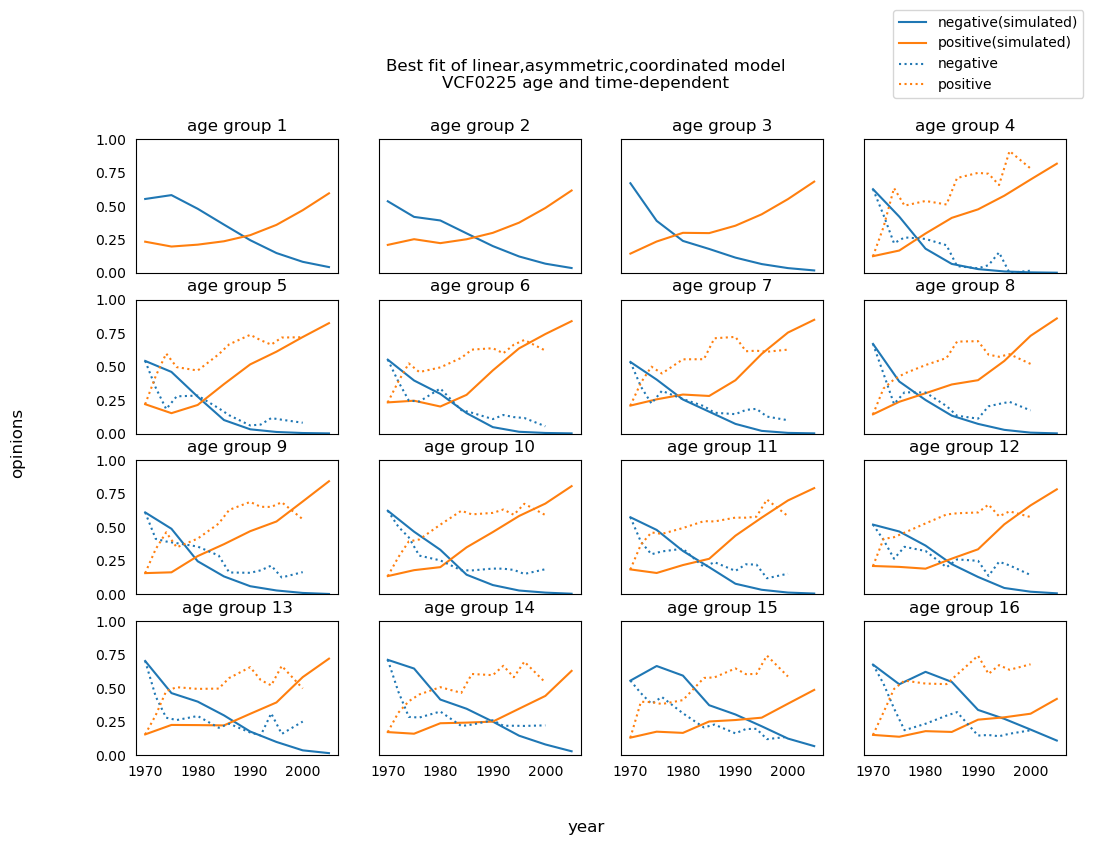

In [441]:
BEL = np.fromfunction(lambda i, j: lacoptat[0] + lacoptat[1] + lacoptat[2] * i +lacoptat[3] * j, (N, tmax-1))
GAL = np.fromfunction(lambda i, j: lacoptat[0] - lacoptat[1] - lacoptat[2] * i - lacoptat[3] * j, (N, tmax-1))
BER = np.fromfunction(lambda i, j: lacoptat[4] + lacoptat[5] + lacoptat[6] * i + lacoptat[7] * j, (N, tmax-1))
GAR = np.fromfunction(lambda i, j: lacoptat[4] - lacoptat[5] - lacoptat[6] * i - lacoptat[7] * j, (N, tmax-1))
for k in range(tmax-1):
    for j in range(1, N):
        if BEL[j,k]*sum(W[j,:]) > 1 or BER[j,k]*sum(W[j, :])>1 or GAL[j,k]*sum(W[j,:]) > 1 or GAR[j,k]*sum(W[j, :])>1:
            print('Warning')
pneg,pneu,ppos = simasym(BEL,BER,GAL,GAR)
# stack plot for the real data
fig, axs = plt.subplots(4,4, sharex = True, sharey = True, figsize = (12,8))
for k in range(16):
    [i,j] = np.unravel_index(k,[4,4])
    #axs[i,j].stackplot(taxis,np.vstack([pneg[k,:],pneu[k,:],ppos[k,:]]))
    axs[i,j].plot(taxis,pneg[k,:],label='negative(simulated)')
    axs[i,j].plot(taxis,ppos[k,:],label='positive(simulated)')
    if k in range(3,16):
        kindex = ~np.isnan(In[:,4,k-3])
        axs[i,j].plot(t[kindex],In[kindex,4,k-3],color='tab:blue',linestyle=':',label='negative')
        axs[i,j].plot(t[kindex],In[kindex,6,k-3],color='tab:orange',linestyle=':',label='positive')             
    axs[i,j].tick_params(left = False, bottom = False)
    axs[i,j].set_title('age group '+str(k+1))
    axs[i,j].set_ylim(0,1)
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
handles, labels = axs[3,3].get_legend_handles_labels()
lgd = fig.legend(handles,labels,loc="upper left", bbox_to_anchor=(0.75,1.05))
fig.suptitle('Best fit of linear,asymmetric,coordinated model\n'+varname+' age and time-dependent')
fig.supxlabel('year')
fig.supylabel('opinions')
plt.savefig('therweightedtimefits/'+'lacfitAT'+varname+'.jpg', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [442]:
def AIC(k, N, SSE):
    return 2*k + N * math.log(SSE/N)
# number of data points
ndp = np.count_nonzero(~np.isnan(In[:,4,:]))
aiclac = AIC(8, ndp, sselacat)
print(round(aiclac,5))
print(round(sselacat,5), '\n', np.around(lacoptat,decimals=5))

-388.59697
11.66142 
 [0.02204 0.01993 0.00014 0.      0.02204 0.01993 0.00014 0.     ]
